# Assignment 1 Group XX
## Question 1


In [57]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from portfolio import Portfolio_Optimizer


In [58]:
index_df = pd.read_excel('PS1_data_clean.xlsx', sheet_name='indices',index_col='date')
fx_df = pd.read_excel('PS1_data_clean.xlsx', sheet_name='currencies',index_col='date')
weight_df = pd.read_excel('PS1_data_clean.xlsx', sheet_name='market_cap')

index_df.head()

,SPTSX INDEX,CAC INDEX,DAX INDEX,SX5E INDEX,NKY INDEX,UKX INDEX,SPX INDEX,IBOV INDEX
date,,,,,,,,
03/30/2007,13165.500000,5634.160156,6917.029785,4181.029785,17287.650391,6308.03,1420.86,45805
04/02/2007,13265.799805,5645.560059,6937.169922,4189.549805,17028.410156,6315.53,1424.55,45597
04/03/2007,13361.200195,5711.910156,7045.560059,4246.299805,17244.050781,6366.11,1437.77,46288
04/04/2007,13448.299805,5739.009766,7073.910156,4261.830078,17544.089844,6364.70,1439.37,46554
04/05/2007,13425.000000,5741.379883,7099.910156,4271.540039,17491.419922,6397.34,1443.76,46647


In [59]:
# convert to dollar
for index in index_df.columns:
    curr = weight_df[weight_df['Ticker'] == index]['Currency'].to_string()[-3:]
    index_df[index] = index_df[index]*fx_df[curr]

In [60]:
logreturns_df = np.log(index_df) - np.log(index_df.shift(1))

mean_values = logreturns_df.mean()
std_deviation = logreturns_df.std()
kurtosis_values = logreturns_df.kurtosis()
skewness_values = logreturns_df.skew()

statistics_table = pd.DataFrame({
    'Mean': mean_values,
    'Standard Deviation': std_deviation,
    'Kurtosis': kurtosis_values,
    'Skewness': skewness_values
})

statistics_table

,Mean,Standard Deviation,Kurtosis,Skewness
SPTSX INDEX,0.000117,0.015251,12.306159,-0.866287
CAC INDEX,0.000025,0.018352,17.583211,0.372231
DAX INDEX,0.000207,0.018058,16.916223,0.410990
SX5E INDEX,-0.000041,0.018481,16.980611,0.283744
NKY INDEX,0.000165,0.016163,16.738605,-0.552431
UKX INDEX,-0.000065,0.015374,10.097418,-0.274447
SPX INDEX,0.000374,0.013581,12.021852,-0.637743
IBOV INDEX,-0.000060,0.024794,11.078068,-0.154794


In [61]:
# Shapiro-Wilk Test
for col in logreturns_df.columns:
    shapiro_stat, shapiro_p_value = shapiro(logreturns_df[col])
    print('p-value for '+col+':', shapiro_p_value)


p-value for SPTSX INDEX: 1.0
p-value for CAC INDEX: 1.0
p-value for DAX INDEX: 1.0
p-value for SX5E INDEX: 1.0
p-value for NKY INDEX: 1.0
p-value for UKX INDEX: 1.0
p-value for SPX INDEX: 1.0
p-value for IBOV INDEX: 1.0


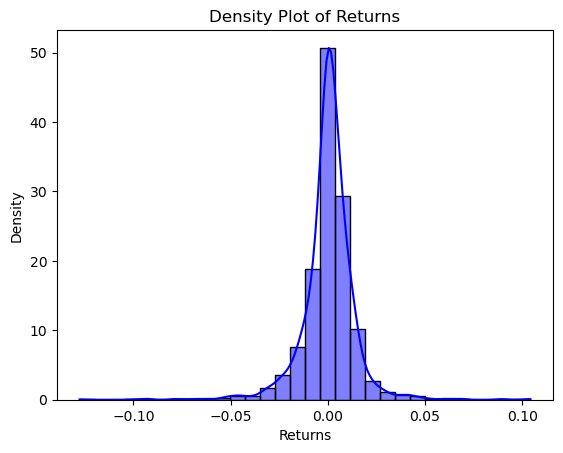

In [62]:
# Assuming 'returns_df' is already defined from your previous code
returns_column = logreturns_df['SPX INDEX']  # Replace 'YourColumnName' with the actual column name

# Plot the density
sns.histplot(returns_column, kde=True, bins=30, color='blue', stat='density')
plt.title('Density Plot of Returns')
plt.xlabel('Returns')
plt.ylabel('Density')
plt.show()


## Question 2 

In [63]:
returns_df = index_df.pct_change().dropna()

portfolio = Portfolio_Optimizer(returns_df)

In [64]:
market_cap_weights = np.array(weight_df['MktCap%'])

custom_weigths = {
    'Mkt Cap Weighted Portfolio': market_cap_weights
}

portfolio.performance_summary(custom_weights=custom_weigths)


Max Sharpe Portfolio:
   - Return: 0.10479054925991783
   - Standard Deviation (Risk): 0.17650261073944815

Min Variance Portfolio:
   - Return: 0.09390923670506174
   - Standard Deviation (Risk): 0.1714903805307943

Equal Weight Portfolio:
   - Return: 0.06216202345229385
   - Standard Deviation (Risk): 0.22268786570377302

Mkt Cap Weighted Portfolio:
   - Return: 0.08969246261501455
   - Standard Deviation (Risk): 0.19599724489887774


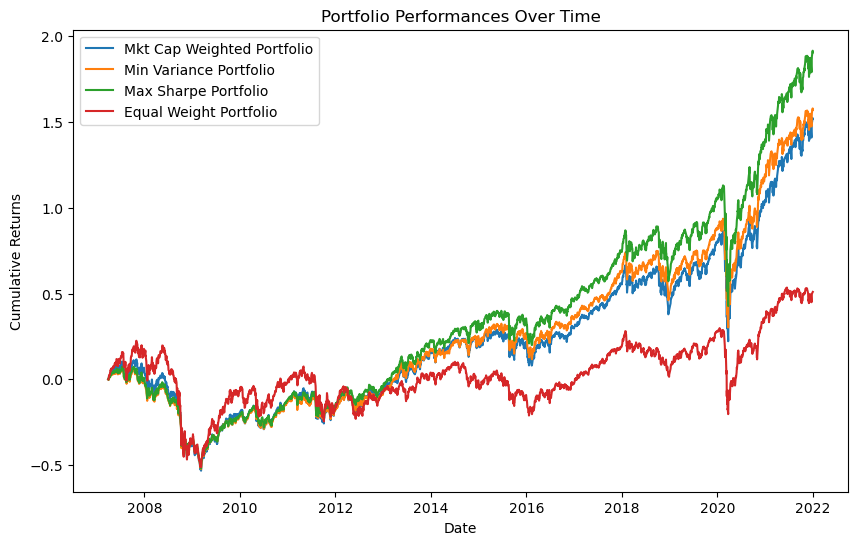

In [65]:
portfolio.plot_performance(index_df, custom_weights=custom_weigths)

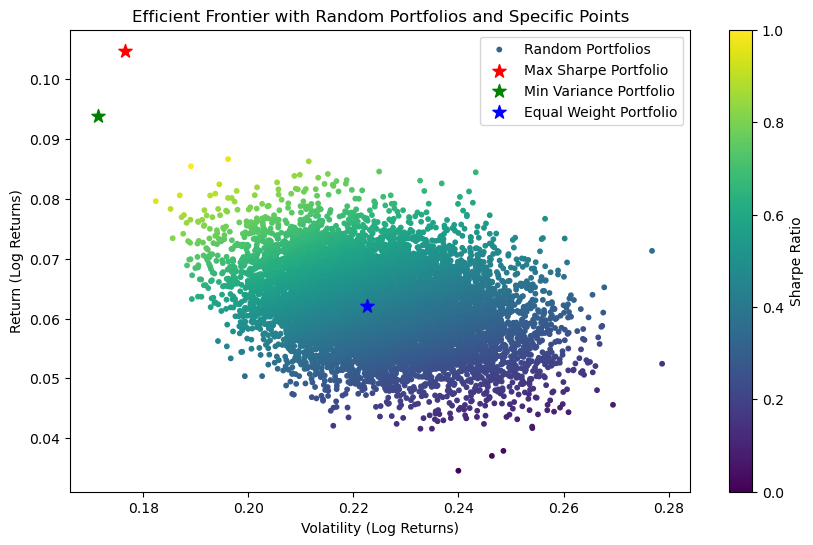

In [66]:
portfolio.plot_efficient_frontier(10000)

## Question 3

In [115]:
rw_returns_df = returns_df.loc['01/04/2008':]


rw_returns_df.index = pd.to_datetime(rw_returns_df.index)
index_df.index = pd.to_datetime(index_df.index)


# Initialize empty DataFrames to store performance values
min_var_df = pd.DataFrame(index=rw_returns_df.index, columns=['Min_Var_Sharpe_performance'])
max_sharpe_df = pd.DataFrame(index=rw_returns_df.index, columns=['Max_Sharpe_performance'])
mkt_cap_df = pd.DataFrame(index=rw_returns_df.index, columns=['Mkt_Cap_performance'])

# Iterate through each rolling window
for year_start in range(2012, 2022):  # Adjust the start year accordingly
    # Define the start and end dates for the current window
    start_date = rw_returns_df.index[rw_returns_df.index.year == year_start - 4].min()
    end_date = rw_returns_df.index[rw_returns_df.index.year == year_start].max()

    # Extract the data for the previous 5 years
    prev_window_data = rw_returns_df.loc[start_date:end_date]

    # Calculate weights for the previous 5 years
    tmp_portfolio = Portfolio_Optimizer(prev_window_data)
    min_var_weights = tmp_portfolio.min_variance_weights
    max_sharpe_weights = tmp_portfolio.max_sharpe_weights

    market_cap_weights = (prev_window_data.mean())/sum(prev_window_data.mean())

    # Extract the data for the current year
    current_window_data = index_df.loc[start_date:end_date]

    # Calculate performance for the current year and store in DataFrames
    min_var_df.loc[start_date:end_date, 'Min_Var_Sharpe_performance'] = np.dot(current_window_data, min_var_weights)
    max_sharpe_df.loc[start_date:end_date, 'Max_Sharpe_performance'] = np.dot(current_window_data, max_sharpe_weights)
    mkt_cap_df.loc[start_date:end_date, 'Mkt_Cap_performance'] = np.dot(current_window_data, market_cap_weights)


# Optionally, concatenate the DataFrames horizontally if needed
portfolio_data = pd.concat([max_sharpe_df, min_var_df, mkt_cap_df], axis=1)

# Filter data from 2013 onwards
portfolio_data = portfolio_data.loc['2013':]


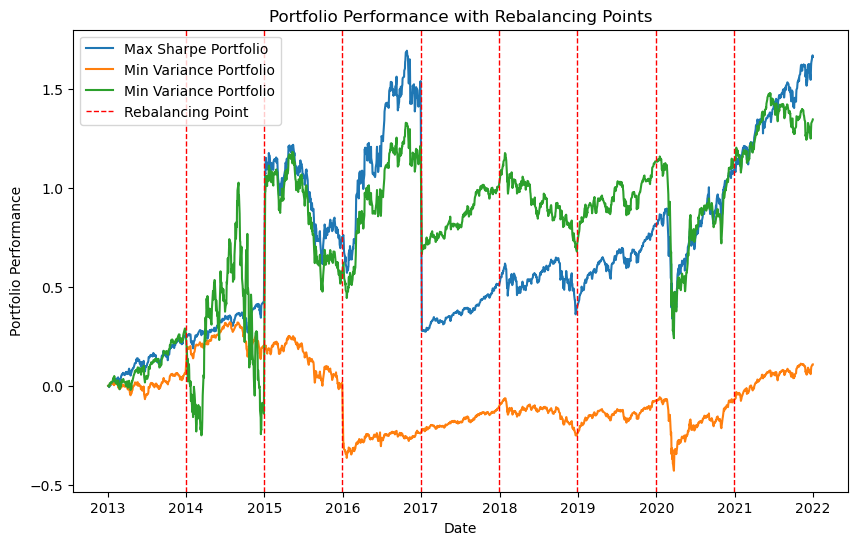

In [116]:
performance_df = (portfolio_data - portfolio_data.iloc[0])/portfolio_data.iloc[0]

# Plot portfolio performance
plt.figure(figsize=(10, 6))
plt.plot(performance_df['Max_Sharpe_performance'], label='Max Sharpe Portfolio')
plt.plot(performance_df['Min_Var_Sharpe_performance'], label='Min Variance Portfolio')
plt.plot(performance_df['Mkt_Cap_performance'], label='Min Variance Portfolio')

# Highlight each rebalancing point
for year_start in range(2013, rw_returns_df.index.year.max()):
    rebalancing_date = rw_returns_df.index[rw_returns_df.index.year == year_start].max()
    plt.axvline(rebalancing_date, color='red', linestyle='--', linewidth=1, label='Rebalancing Point' if year_start == 2013 else '')

plt.title('Portfolio Performance with Rebalancing Points')
plt.xlabel('Date')
plt.ylabel('Portfolio Performance')
plt.legend()
plt.show()

In [114]:
def calculate_stats(pfolio):
    returns = pfolio.pct_change().dropna()
    mu = returns.mean()*250
    sigma = returns.std()* np.sqrt(250)
    sharpe = mu/sigma
    return (mu, sigma, sharpe)

print("Max Sharpe Portfolio:")
print("   - Return:", calculate_stats(portfolio_data['Max_Sharpe_performance'])[0])
print("   - Standard Deviation (Risk):", calculate_stats(portfolio_data['Max_Sharpe_performance'])[1])
print("   - Sharpe Ratio:", calculate_stats(portfolio_data['Max_Sharpe_performance'])[2])
print("\nMin Variance Portfolio:")
print("   - Return:", calculate_stats(portfolio_data['Min_Var_Sharpe_performance'])[0])
print("   - Standard Deviation (Risk):", calculate_stats(portfolio_data['Min_Var_Sharpe_performance'])[1])
print("   - Sharpe Ratio:", calculate_stats(portfolio_data['Min_Var_Sharpe_performance'])[2])
print("\nMkt Cap Weight Portfolio:")
print("   - Return:", calculate_stats(portfolio_data['Mkt_Cap_performance'])[0])
print("   - Standard Deviation (Risk):", calculate_stats(portfolio_data['Mkt_Cap_performance'])[1])
print("   - Sharpe Ratio:", calculate_stats(portfolio_data['Mkt_Cap_performance'])[2])


Max Sharpe Portfolio:
   - Return: 0.17569805381444356
   - Standard Deviation (Risk): 0.30681048873249495
   - Sharpe Ratio: 0.5726598674650689

Min Variance Portfolio:
   - Return: 0.033447244647250816
   - Standard Deviation (Risk): 0.194839993073149
   - Sharpe Ratio: 0.17166519111245132

Mkt Cap Weight Portfolio:
   - Return: 0.2330256805507242
   - Standard Deviation (Risk): 0.5884898765861536
   - Sharpe Ratio: 0.3959722840136397
